In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
root_path = '/content/drive/MyDrive/CS583/'

In [8]:
image_df = pd.read_csv(root_path+'image_df.csv')
image_df['Prediction'] = image_df['Prediction'].astype(str)
image_df

,Company,Image_Path,Start_Date,End_Date,Prediction
0,MSFT,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2013-01-02,2013-01-30,0
1,MSFT,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2013-01-16,2013-02-13,1
2,MSFT,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2013-01-31,2013-02-28,1
3,MSFT,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2013-02-14,2013-03-14,0
4,MSFT,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2013-03-01,2013-03-28,0
...,...,...,...,...,...
2485,JNJ,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2022-09-12,2022-10-07,1
2486,JNJ,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2022-09-26,2022-10-21,1
2487,JNJ,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2022-10-10,2022-11-04,1
2488,JNJ,/content/drive/MyDrive/Colab Notebooks/CS583 P...,2022-10-24,2022-11-18,0


In [9]:
image_df['Prediction'].to_list().count('0'), image_df['Prediction'].to_list().count('1')

(1207, 1283)

In [10]:
new_paths = []
for i in range(len(image_df)):
  new_paths.append( root_path+ image_df['Image_Path'][0].split('/GAF/')[1])

image_df['Image_Path'] = new_paths

In [11]:
image_df.head()

,Company,Image_Path,Start_Date,End_Date,Prediction
0,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-02,2013-01-30,0
1,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-16,2013-02-13,1
2,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-31,2013-02-28,1
3,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-02-14,2013-03-14,0
4,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-03-01,2013-03-28,0


In [12]:
batch_size = 32
image_size = (255,255)

(800, 800, 3)
(255, 255, 3)


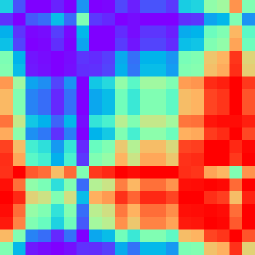

In [13]:
image = cv2.imread(image_df['Image_Path'][0])
print(image.shape)
image = cv2.resize(image, image_size)
print(image.shape)
cv2_imshow(image)

In [14]:
#splitting data
train_df, test_df = train_test_split(image_df, test_size=0.15, random_state=42)
print(train_df.shape, test_df.shape)

(2116, 5) (374, 5)


In [15]:
#defining data generators

train_validate_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.06)  # set validation split
test_datagen = ImageDataGenerator(rescale=1/255)


In [16]:
train_validate_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.1,  # Fraction of total width for random horizontal shifts
    height_shift_range=0.1, # Fraction of total height for random vertical shifts
    shear_range=0.2,        # Shear Intensity
    zoom_range=0.2,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest',     # Strategy for filling in newly created pixels
    validation_split=0.06,
)
test_datagen = ImageDataGenerator(rescale=1/255)

In [17]:
train_generator = train_validate_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',  # Column containing the image paths
    y_col='Prediction',  # Column containing the labels
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    shuffle=False,
    subset='training'
)

validation_generator = train_validate_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',  # Column containing the image paths
    y_col='Prediction',  # Column containing the labels
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',  # Column containing the image paths
    y_col='Prediction',  # Column containing the labels
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    shuffle=False  # No need to shuffle test data
)

Found 1990 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.
Found 374 validated image filenames belonging to 2 classes.


In [21]:
model = tf.keras.models.Sequential([
            #  First Convolution
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(255, 255, 3)),
            BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.4),

            # Second Convolution
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.4),

            # Third Convolution
            Conv2D(128, kernel_size=4, activation='relu'),
            BatchNormalization(),
            Flatten(),
            Dropout(0.4),
            # Output layer
            Dense(1, activation='sigmoid')]
        )

In [ ]:
model = tf.keras.models.Sequential([
            #  First Convolution
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(255, 255, 3)),
            #BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), activation='relu'),
            #BatchNormalization(),
            Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.1),

            # Second Convolution
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            #BatchNormalization(),
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            #BatchNormalization(),
            Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            # Third Convolution
            Conv2D(128, kernel_size=4, activation='relu'),
            BatchNormalization(),
            Flatten(),
            Dropout(0.4),
            # Output layer
            Dense(1, activation='sigmoid')]
        )

In [ ]:
#model = Sequential([
    # Convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])


In [22]:
#big model without regularizers
model = Sequential([
    # Convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])


In [16]:
#big model with l2 reg and padding

model = Sequential([
    # Convolutional layers
    Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])


In [ ]:
model = Sequential([
    # Convolutional layers with different kernel sizes and padding
    Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])

In [ ]:

model = Sequential([
    Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(20, 20, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
#CALLBACKS
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=0, factor=0.5, min_lr=0.00001) #updates learning rate dynamically
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)


In [27]:
history = model.fit_generator(train_generator,
                                     epochs=2,
                                    steps_per_epoch=len(train_generator),
                                     validation_data=validation_generator,
                                     #callbacks=[learning_rate_reduction,early_stopping],
                                    #callbacks=[early_stopping],
                              )

<ipython-input-27-c0e3404a004c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/2
63/63 [==============================] - 81s 1s/step - loss: 3.3717 - acc: 0.4849 - val_loss: 3.6117 - val_acc: 0.4921
Epoch 2/2
63/63 [==============================] - 63s 1s/step - loss: 5.5833 - acc: 0.4990 - val_loss: 2.5335 - val_acc: 0.4921


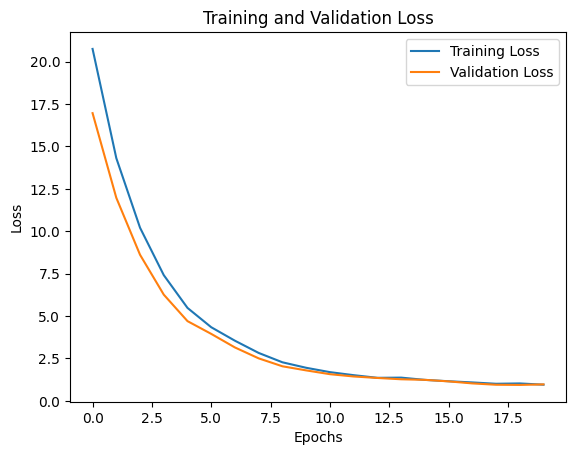

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
scores = model.evaluate_generator(test_generator)
print("{0}s: {1}%".format(model.metrics_names[1], scores[1]*100))


<ipython-input-21-03bd2fb4e750>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


accs: 50.267380475997925%


In [22]:
#predicting on the test set
predictions = model.predict_generator(test_generator)
binary_predictions = (predictions > 0.5).astype(int)
print(np.unique(binary_predictions, return_counts=True))

true_labels = test_generator.classes #ground truth labels

#getting the classification report and the F1 scores
f1 = classification_report(true_labels, binary_predictions)
print("F1 Score: ", f1_score(true_labels, binary_predictions))
print( f1)


<ipython-input-22-4074a5c9daad>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


(array([0, 1]), array([191, 183]))
F1 Score:  0.5053763440860215
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       185
           1       0.51      0.50      0.51       189

    accuracy                           0.51       374
   macro avg       0.51      0.51      0.51       374
weighted avg       0.51      0.51      0.51       374



In [23]:
confusion_matrix(true_labels, binary_predictions)

array([[96, 89],
       [95, 94]])

In [33]:
#random model

In [18]:
class RandomActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(RandomActivation, self).__init__()

    def call(self, inputs):
        # Introduce randomness with uniform distribution
        random_values = tf.random.uniform(tf.shape(inputs), minval=-1.0, maxval=1.0)
        return random_values

model = tf.keras.models.Sequential([
    # First Convolution
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=RandomActivation(), input_shape=(255, 255, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Second Convolution
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Third Convolution
    tf.keras.layers.Conv2D(128, kernel_size=4, activation=RandomActivation()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()

In [47]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # First Convolution
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='sigmoid', input_shape=(255, 255, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Second Convolution
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Third Convolution
    tf.keras.layers.Conv2D(128, kernel_size=4, activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Random weight initialization
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        weights_initializer = tf.random_uniform_initializer(minval=-1, maxval=1)
        bias_initializer = tf.random_uniform_initializer(minval=-1, maxval=1)
        layer.kernel_initializer = weights_initializer
        layer.bias_initializer = bias_initializer

In [40]:
model.save(root_path+'models/model_20ep_55acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


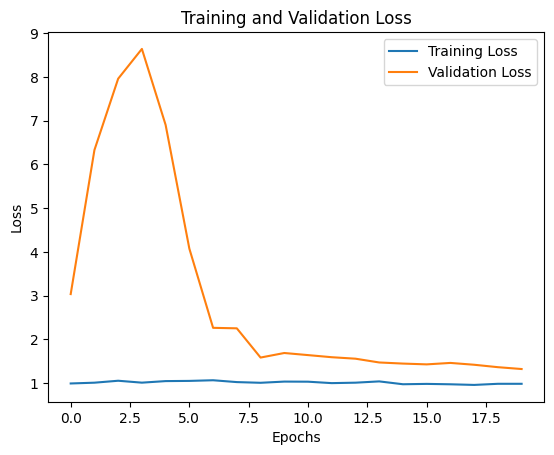

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
#load saved model
loaded_model = tf.keras.models.load_model(root_path+'models/model_5ep_55acc.h5')


In [ ]:
loaded_model.summary()


In [14]:
scores = loaded_model.evaluate_generator(test_generator, steps=5)
print("{0}s: {1}%".format(loaded_model.metrics_names[1], scores[1]*100))


<ipython-input-14-5fb9822fef24>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = loaded_model.evaluate_generator(test_generator, steps=5)


accs: 53.75000238418579%


In [15]:
scores, loaded_model.metrics_names

([12.330488204956055, 0.5375000238418579], ['loss', 'acc'])

In [16]:
predictions = loaded_model.predict_generator(test_generator)
binary_predictions = (predictions > 0.5).astype(int)

<ipython-input-16-f7f04e74b501>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = loaded_model.predict_generator(test_generator)


In [18]:
true_labels = test_generator.classes

In [19]:
#getting the classification report and the F1 scores
f1 = classification_report(true_labels, binary_predictions)
print("F1 Score: ", f1_score(true_labels, binary_predictions))
print( f1)

F1 Score:  0.0
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       185
           1       0.00      0.00      0.00       189

    accuracy                           0.49       374
   macro avg       0.25      0.50      0.33       374
weighted avg       0.24      0.49      0.33       374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
confusion_matrix(true_labels, binary_predictions)

array([[185,   0],
       [189,   0]])